In [1]:
# Import python modules

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from scipy.stats import ttest_ind
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold

/home/csi20local/snap/jupyter/common/lib/python3.7/site-packages/joblib/_multiprocessing_helpers.py:45: UserWarning: [Errno 13] Permission denied.  joblib will operate in serial mode
  warnings.warn('%s.  joblib will operate in serial mode' % (e,))


In [2]:
# Full 30 Case List

FullCaseList = ['01', '02', '05', '06', '07', '08', '09', '10', '12', '14', '15', '16',
                '17', '18', '19', '20', '21', '23', '24', '25', '26', '27', '28', '29',
                '30', '32']
FullCaseList = ['CT-CRT-' + case for case in FullCaseList]
AddCases = ['EBR-01', 'EBR-02', 'Normal-1', 'Normal-3']
FullCaseList = FullCaseList + AddCases

# FIMH 10 Case List

FIMHCaseList = ['01', '02', '05', '06', '07', '08', '09', '12', '15', '16']
FIMHCaseList = ['CT-CRT-' + case for case in FIMHCaseList]

# Sklearn method to do 10-fold cv split into random train, test cases

kf = KFold(n_splits=10, shuffle=True)

# Create char array of 30 Case list

Cases_charar = np.chararray((30,), itemsize=9)
Cases_charar[:] = FullCaseList

In [3]:
# Example Code on KFold scikit learn tutorial

# for i, j in kf.split(FullCaseList):
#     print("Training indices: ", i, "Testing indices: ", j)
#     Cases_train, Cases_test = FullCaseList[i], FullCaseList[j]

# for i, j in kf.split(FullCaseList):
#     print("Training indices: ", i, "Testing indices: ", j)
#     Cases_train, Cases_test = Cases_charar[i], Cases_charar[j]

In [4]:
# Not sure what this code does

# train_cases_n = np.zeros(train_cases.shape)
# test_cases_n = np.zeros(test_cases.shape)

# train_cases_n = train_cases_n.astype(int)
# test_cases_n = test_cases_n.astype(int)

# train_cases_f1 = [FullCaseList[i] for i in train_cases[0]]
# train_cases_f1

In [5]:
# Failed attempt to vectorise what the cell above does

# for j in range(0, train_cases.shape[0]):    
#     cases_list = [FullCaseList[i] for i in train_cases[j]]
#     train_cases_n[j, :] = np.asarray(cases_list)

# cases_list

# np.asarray(cases_list)

# train_cases_n[0, :] = [FullCaseList[i] for i in train_cases[0]]

In [6]:
# This cell generates a list of all errors types

import os

path = "/home/csi20local/Data/RG_CT_Cases/CT-CRT-05/"

path_contents = os.listdir(path)

start_letter = "MT-HiRes"
end_letter = ".csv"
MT_HiRes_files = [x for x in path_contents if x.startswith(start_letter) and x.endswith(end_letter)]

all_errors = []

for i in MT_HiRes_files:
    error = i.replace('MT-HiRes-', '')
    
    all_errors.append(error)

for i in range(0, len(all_errors)):
    
    if 'AbsoluteError' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-AbsoluteError.csv', '')
    
    if 'PercentageErrors' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-PercentageErrors.csv', '')
        
    if 'Results' in all_errors[i]:
        all_errors[i] = all_errors[i].replace('-Results.csv', '')
        
    if 'Normal' in all_errors[i]:
        all_errors[i] = 'ASD'
        
    if 'Hausdorff' in all_errors[i]:
        all_errors[i] = 'DHD'

In [7]:
"""
Calculates unified z-score of all (SW,BE) combo's across a provided list of cases for training. 

INPUT: List of cases. Error type.

OUTPUT: Mean, std deviation, DataFrame of medians (across cases) of each hyperparameter combination, DataFrame of
        z score of each hyperparameter combination across cases
"""

def S_unified(case_list, Error):
    
    # Dict to convert error nickname to csv filename
    error_dict = {'ASD': 'Normal-Distance-Results', 'DHD': 'Hausdorff-Distance-Results', 'Dice': 'Dice-Results',
                 'LAA': 'LAA-AbsoluteError', 'LSPV': 'LSPV-AbsoluteError', 'LIPV': 'LIPV-AbsoluteError',
                 'RSPV': 'RSPV-AbsoluteError', 'RIPV': 'RIPV-AbsoluteError',
                 'LAA-LS': 'LAA-LS-PercentageErrors', 'LAA-LI': 'LAA-LI-PercentageErrors', 
                 'LAA-RS': 'LAA-RS-PercentageErrors', 'LAA-RI': 'LAA-RS-PercentageErrors',
                 'LS-LI': 'LS-LI-PercentageErrors', 'LS-RS': 'LS-RS-PercentageErrors', 
                 'LS-RI': 'LS-RI-PercentageErrors', 'LI-RS': 'LI-RS-PercentageErrors', 
                 'LI-RI': 'LI-RI-PercentageErrors', 'RS-RI': 'RS-RI-PercentageErrors',
                 'MV': 'MV-AbsoluteError'}
    
    Error = error_dict[Error]
    
    # Omit cases which lack LAA in the LAA error calculation
    if 'LAA' in Error:
            case_list = list(case_list)
            if 'CT-CRT-09' in case_list:
                case_list.remove('CT-CRT-09')
            
            case_list = tuple(case_list)
            
    # Omit cases which lack LI in the LI error calculation
    if 'LI' in Error:
            case_list = list(case_list)
            if 'CT-CRT-18' in case_list:
                case_list.remove('CT-CRT-18')
            
            if 'CT-CRT-23' in case_list:
                case_list.remove('CT-CRT-23')
                
            if 'Normal-3' in case_list:    
                case_list.remove('Normal-3')
            
            case_list = tuple(case_list)
    
    # Create array to hold errors across cases for each (SW,BE) participant
    cases_array = np.zeros(shape=(63,len(case_list)))
    
    # Create list of cases with 20 time frames
    TDownsampledCases = ['21', '23', '24', '25', '26', '27', '28', '29', '30', '32']
    TDownsampledCases = ['CT-CRT-' + case for case in TDownsampledCases]
    TDownsampledCases_add = ['EBR-01', 'EBR-02']
    TDownsampledCases = TDownsampledCases + TDownsampledCases_add
        
    for Case in case_list:
        
        if Case in TDownsampledCases:
            df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/{Case}/MT-HiRes-TDownsampled-{Error}.csv', 
                        sep = ' ', index_col = 0)
            df_array = df_read.to_numpy() 
            flattened_array = np.reshape(df_array, 63) # flatten array to 1D array with 63 elements
    
            cases_array[:, case_list.index(Case)] = flattened_array # assign flattened array to corresponding case col.
    
        else:
            df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/{Case}/MT-HiRes-{Error}.csv', 
                        sep = ' ', index_col = 0)
            df_array = df_read.to_numpy()
            flattened_array = np.reshape(df_array, 63)
                
            cases_array[:, case_list.index(Case)] = flattened_array
                
    # Create array for medians of errors for each (SE, BE) combo across cases
    medians = np.zeros(63)

    for i in range(0,cases_array.shape[0]):
        # Take median across case columns for each (SW,BE) participant and assign to medians array
        medians[i] = np.median(cases_array[i, :])
            
    # Find mean and std dev of medians across 63 (SW, BE) combinations
    mean = np.mean(medians)
    std = np.std(medians)
        
    BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
    SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
  
    # Create Dataframe of Median error for each (SW, BE) combination 
    df_medians = np.reshape(medians, (9,7))
    df_medians = pd.DataFrame(df_medians)
    df_medians = df_medians.rename(index = BE_rename, columns=SW_rename)
    
    # Create Dataframe of Z scores for each (SE, BE) combination
    df_zscore = (df_medians-mean)/std
    df_zscore = df_zscore.rename(index = BE_rename, columns=SW_rename)
    
    if Error == "Dice-Results":
        
        # Correct mean and medians in the case of minimising DSC means improving segmentation
        mean = 1 - mean
        df_medians = 1 - df_medians
        
        df_zscore = (df_medians-mean)/std
#         df_zscore = 1 - df_zscore # Old code
    
    return mean, std, df_medians, df_zscore

In [41]:
# FOR ALL 19 ERRORS

# Doing 10-fold cross validation

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:

#     print("Here")
#     print(type(train_cases))
#     print("Len of train_cases: ", len(train_cases))
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, all_errors[0])[-1]

    # Sum the remaining errors' Z-scores to df
    for i in range(1, len(all_errors)):
        df = df + S_unified(train_cases, all_errors[i])[-1]
    
    # Mean across all 19 types of error
    df = df / 19
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_all_errors = df_sum / 10

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [42]:
df_all_errors

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,0.173050,0.005649,-0.117356,0.071424,-0.194436,0.020218,-0.309059
1.000000e-06,-0.332330,0.459330,0.162957,-0.042774,-0.025397,-0.105005,0.191874
4.000000e-07,-0.247946,0.216495,0.168702,0.053039,-0.244328,-0.144587,-0.101604
1.000000e-07,0.072871,0.294386,-0.145411,0.239041,0.064839,0.551870,-0.335718
4.000000e-08,0.095385,-0.160286,0.293053,0.161715,-0.198832,-0.197031,-0.034553
1.000000e-08,0.164172,0.277252,0.062035,0.104804,-0.283117,-0.338842,-0.289979
4.000000e-09,-0.077796,0.249955,0.174342,-0.075912,-0.204023,0.276466,-0.402529
1.000000e-09,0.080039,0.237930,0.083113,-0.149221,0.022869,-0.167102,-0.279935
4.000000e-10,-0.284558,-0.036667,0.413264,-0.018856,0.211773,0.190768,-0.299492


In [43]:
df_all_errors.min()

9e-2   -0.332330
3e-2   -0.160286
9e-3   -0.145411
3e-3   -0.149221
9e-4   -0.283117
3e-4   -0.338842
0.0    -0.402529
dtype: float64

In [44]:
df_all_errors.min().min()

-0.40252857305962425

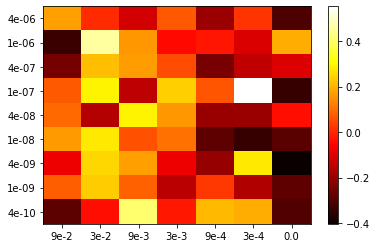

In [53]:
plt.pcolor(df_all_errors, cmap='hot')

plt.yticks(np.arange(0.5, len(df_all_errors.index), 1), df_all_errors.index)
# set y-axis as indices

plt.xticks(np.arange(0.5, len(df_all_errors.columns), 1), df_all_errors.columns)
# set x-axis as columns

plt.colorbar()
plt.gca().invert_yaxis()

In [14]:
# Doing 10-fold cross validation but with ONLY ASD as the error metric

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:

#     print("Here")
#     print(type(train_cases))
#     print("Len of train_cases: ", len(train_cases))
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, 'ASD')[-1]
    
    # Mean across all 19 types of error
#     df = df / 19
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_ASD = df_sum / 10

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [15]:
df_ASD

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,1.056037,-0.199306,-1.396099,-0.480996,-1.070721,0.068230,-0.008946
1.000000e-06,-0.089986,0.085135,0.207472,-0.479503,1.175374,-0.658588,-0.149118
4.000000e-07,-1.079167,-0.627632,1.398595,1.726730,0.019779,-0.496263,-0.962686
1.000000e-07,-0.476499,0.819980,1.356076,0.161049,0.056409,1.105217,0.348774
4.000000e-08,-0.614106,-0.460156,1.053929,0.302789,0.700267,-0.940369,-0.386846
1.000000e-08,-1.004030,-0.406869,-0.259038,0.654561,-0.512064,-0.076415,-1.120185
4.000000e-09,0.353438,0.514143,2.425733,-0.169090,0.064114,-0.105404,0.232050
1.000000e-09,0.472031,0.895465,-0.422501,0.070881,-0.112499,-1.562683,-1.352667
4.000000e-10,0.319655,-0.120554,-0.753398,0.949051,1.513611,-0.445090,-1.107104


In [16]:
df_ASD.min()

9e-2   -1.079167
3e-2   -0.627632
9e-3   -1.396099
3e-3   -0.480996
9e-4   -1.070721
3e-4   -1.562683
0.0    -1.352667
dtype: float64

In [17]:
df_ASD.min().min()

-1.5626831891458708

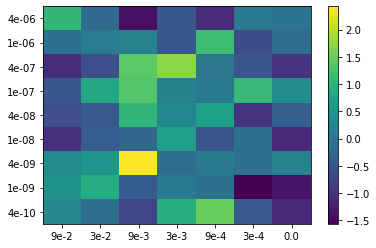

In [18]:
plt.pcolor(df_ASD)

plt.yticks(np.arange(0.5, len(df_ASD.index), 1), df_ASD.index)
# set y-axis as indices

plt.xticks(np.arange(0.5, len(df_ASD.columns), 1), df_ASD.columns)
# set x-axis as columns

plt.colorbar()
plt.gca().invert_yaxis()

In [20]:
# Doing 10-fold cross validation but with ALL 3 global error metrics

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:

#     print("Here")
#     print(type(train_cases))
#     print("Len of train_cases: ", len(train_cases))
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, 'ASD')[-1]
    df = df + S_unified(train_cases, 'DHD')[-1]
    df = df + S_unified(train_cases, 'Dice')[-1]
    
    # Mean across all types of error
    df = df / 3
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_globals = df_sum / 10

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [21]:
df_globals

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,0.582983,-0.856226,-1.103503,0.108783,-0.238175,-0.138285,-0.134123
1.000000e-06,-0.342475,1.374280,-0.024605,-0.818329,0.848433,-0.065855,-0.629724
4.000000e-07,-0.446679,-0.716671,0.931705,0.722785,-0.220421,-0.518320,-0.775364
1.000000e-07,-0.491837,0.652732,0.447188,0.848293,0.249717,1.185797,-0.197791
4.000000e-08,-0.245632,-0.241439,0.813745,0.187571,-0.431404,-0.474831,-0.487637
1.000000e-08,0.273030,0.337137,0.608878,0.220521,-0.755221,-0.351510,-1.181290
4.000000e-09,0.345518,0.851103,1.064360,-0.020888,-0.599626,0.398104,-0.046273
1.000000e-09,0.065809,0.463190,0.155541,-0.242967,0.419587,-0.709860,-1.147376
4.000000e-10,0.084635,0.089128,0.058291,0.522542,0.728262,0.068056,-1.053372


In [22]:
df_globals.min()

9e-2   -0.491837
3e-2   -0.856226
9e-3   -1.103503
3e-3   -0.818329
9e-4   -0.755221
3e-4   -0.709860
0.0    -1.181290
dtype: float64

In [23]:
df_globals.min().min()

-1.1812895177808869

In [ ]:
plt.pcolor(df_globals)

plt.yticks(np.arange(0.5, len(df_globals.index), 1), df_globals.index)
# set y-axis as indices

plt.xticks(np.arange(0.5, len(df_globals.columns), 1), df_globals.columns)
# set x-axis as columns

plt.colorbar()
plt.gca().invert_yaxis()

In [25]:
# Doing 10-fold cross validation but with ONLY local absolute error metrics

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:

#     print("Here")
#     print(type(train_cases))
#     print("Len of train_cases: ", len(train_cases))
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, 'LAA')[-1]
    df = df + S_unified(train_cases, 'LSPV')[-1]
    df = df + S_unified(train_cases, 'LIPV')[-1]
    df = df + S_unified(train_cases, 'RSPV')[-1]
    df = df + S_unified(train_cases, 'RIPV')[-1]
    df = df + S_unified(train_cases, 'MV')[-1]
    
    # Mean across all types of error
    df = df / 6
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_local_abs = df_sum / 10

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [26]:
df_local_abs

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,-0.001687,0.143215,0.137110,0.285110,0.089699,0.160749,0.230854
1.000000e-06,-0.323640,-0.094739,0.281006,0.061469,-0.366186,0.134443,0.175269
4.000000e-07,-0.170489,0.273171,0.314791,-0.065017,-0.346492,0.372981,-0.209093
1.000000e-07,0.114651,-0.077653,-0.275998,-0.208950,-0.300922,0.408938,-0.295454
4.000000e-08,-0.114076,0.270782,-0.059892,0.065114,-0.725537,-0.336038,-0.226534
1.000000e-08,0.077022,0.265652,0.121384,0.339416,-0.168293,-0.292954,-0.322767
4.000000e-09,-0.031925,0.249124,0.313439,0.185797,-0.284266,0.129024,-0.590835
1.000000e-09,-0.128440,0.240405,0.137010,-0.146711,0.319633,-0.022055,0.105519
4.000000e-10,-0.268671,-0.389624,0.424904,-0.335616,0.606217,0.086780,0.059875


In [27]:
df_local_abs.min()

9e-2   -0.323640
3e-2   -0.389624
9e-3   -0.275998
3e-3   -0.335616
9e-4   -0.725537
3e-4   -0.336038
0.0    -0.590835
dtype: float64

In [28]:
df_local_abs.min().min()

-0.7255368300046741

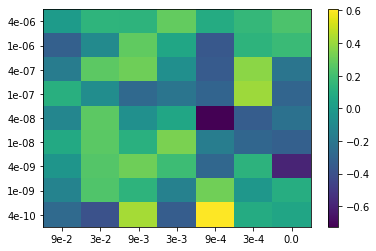

In [29]:
plt.pcolor(df_local_abs)

plt.yticks(np.arange(0.5, len(df_local_abs.index), 1), df_local_abs.index)
# set y-axis as indices

plt.xticks(np.arange(0.5, len(df_local_abs.columns), 1), df_local_abs.columns)
# set x-axis as columns

plt.colorbar()
plt.gca().invert_yaxis()

In [30]:
# Doing 10-fold cross validation but with ONLY local PERCENTAGE error metrics

# Split 30 Case list into training and test sets using 10-fold cv
kf_split = list(kf.split(FullCaseList))

# Create arrays that contain indicies of training and testing cases for each of 10 folds

train_cases_ind = np.zeros((10, 27))
test_cases_ind = np.zeros((10, 3))
train_cases_ind = train_cases_ind.astype(int)
test_cases_ind = test_cases_ind.astype(int)

for i in range(0, train_cases_ind.shape[0]):
    
    train_cases_ind[i, :] = kf_split[i][0]
    test_cases_ind[i, :] = kf_split[i][1]
    
# Create lists that contain training and testing cases for each fold.
# Length of lists is 10 as there are 10 folds.

# The i'th element of each list is a list of training/testing case names in i'th fold

train_cases_folds = [] 
test_cases_folds = []

for i in range(0, train_cases_ind.shape[0]):
    train_cases_folds.append([FullCaseList[i] for i in train_cases_ind[i]])
    test_cases_folds.append([FullCaseList[i] for i in test_cases_ind[i]])

# Create array to sum Z-scores from each fold
sum_folds_ar = np.zeros((9,7))

# For every set of training cases in each fold:
for train_cases in train_cases_folds:

#     print("Here")
#     print(type(train_cases))
#     print("Len of train_cases: ", len(train_cases))
    
    # Create df of Z-scores using first error
    df = S_unified(train_cases, 'LAA-LS')[-1]
    df = df + S_unified(train_cases, 'LAA-LI')[-1]
    df = df + S_unified(train_cases, 'LAA-RS')[-1]
    df = df + S_unified(train_cases, 'LAA-RI')[-1]
    df = df + S_unified(train_cases, 'LS-LI')[-1]
    df = df + S_unified(train_cases, 'LS-RS')[-1]
    df = df + S_unified(train_cases, 'LS-RI')[-1]
    df = df + S_unified(train_cases, 'LI-RS')[-1]
    df = df + S_unified(train_cases, 'LI-RI')[-1]
    df = df + S_unified(train_cases, 'RS-RI')[-1]
    
    # Mean across all types of error
    df = df / 10
    
    # Add Z-score Dataframe from all 19 errors to sum_folds_ar
    print("Adding df to sum_folds_ar")
    sum_folds_ar = sum_folds_ar + df.to_numpy()

df_sum = pd.DataFrame(sum_folds_ar)

BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
df_sum = df_sum.rename(index = BE_rename, columns=SW_rename)
df_local_percent = df_sum / 10

Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar
Adding df to sum_folds_ar


In [31]:
df_local_percent

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,0.092376,0.163672,0.014280,-0.094122,-0.299481,0.055113,-0.664776
1.000000e-06,-0.361172,0.510004,0.145200,0.075622,-0.080220,-0.318991,0.469347
4.000000e-07,-0.290901,0.327226,-0.157305,-0.130559,-0.174795,-0.401473,0.296525
1.000000e-07,0.239205,0.316133,-0.222952,0.372858,0.315381,0.407162,-0.344038
4.000000e-08,0.197737,-0.257485,0.294833,0.242588,0.106679,-0.006358,0.069148
1.000000e-08,0.255758,0.172816,-0.000946,-0.019400,-0.294856,-0.237118,0.046450
4.000000e-09,-0.108374,0.083253,-0.121395,-0.296325,-0.050567,0.172351,-0.382932
1.000000e-09,0.246618,0.153521,-0.016483,-0.031818,-0.221852,-0.030758,-0.150297
4.000000e-10,-0.433722,0.127694,0.461456,0.088461,-0.194419,0.186300,-0.309880


In [32]:
df_local_percent.min()

9e-2   -0.433722
3e-2   -0.257485
9e-3   -0.222952
3e-3   -0.296325
9e-4   -0.299481
3e-4   -0.401473
0.0    -0.664776
dtype: float64

In [33]:
df_local_percent.min().min()

-0.6647756395949153

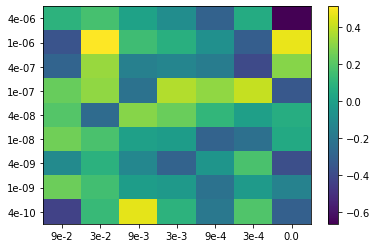

In [34]:
plt.pcolor(df_local_percent)

plt.yticks(np.arange(0.5, len(df_local_percent.index), 1), df_local_percent.index)
# set y-axis as indices

plt.xticks(np.arange(0.5, len(df_local_percent.columns), 1), df_local_percent.columns)
# set x-axis as columns

plt.colorbar()
plt.gca().invert_yaxis()

## Results of 10-fold cross validation

Optimal (SW, BE) combinations from repeating 10-fold cross validation:

* SW = 0.0, BE = 4e-7. Freq: 1
* SW = 0.0, BE = 1e-7. Freq: 3
* SW = 0.0, BE = 4e-9. Freq: 6

Repeating again:

* SW = 0.0, BE = 1e-7. Freq: 3
* SW = 0.0, BE = 4e-9. Freq: 6
* SW = 9e-4, BE = 1e-8. Freq: 1


## Results of using 30 Cases as Training set

SW = 3e-4, BE = 1e-8

Odd that it's different to all of the previous attempts at 10-fold cross validation?

In [133]:
# Create df of Z-scores using first error
df = S_unified(FullCaseList, all_errors[0])[-1]

# Sum the remaining errors' Z-scores
for i in range(1, len(all_errors)):
    df = df + S_unified(FullCaseList, all_errors[i])[-1]
    
df = df/19

In [134]:
df

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,0.186329,-0.004837,-0.027396,-0.136285,-0.082380,0.021215,-0.321870
1.000000e-06,-0.414401,0.685947,0.233900,-0.029469,-0.094607,-0.139320,0.252780
4.000000e-07,-0.346951,0.233578,0.330796,0.165268,-0.137186,-0.048822,0.053522
1.000000e-07,0.090823,0.402720,-0.153867,0.330894,0.081499,0.638616,-0.339343
4.000000e-08,0.165779,-0.096985,0.620386,0.145307,-0.253869,-0.235236,0.032944
1.000000e-08,0.116811,0.506891,0.131689,0.098676,-0.312251,-0.536264,-0.289191
4.000000e-09,0.074104,0.462542,0.332261,0.063128,-0.034539,0.265869,-0.446679
1.000000e-09,0.135827,0.380691,0.105663,-0.055893,0.085496,-0.026093,-0.173838
4.000000e-10,-0.249576,0.100355,0.407781,0.108038,0.166383,0.258626,-0.170197


In [135]:
df.min()

9e-2   -0.414401
3e-2   -0.096985
9e-3   -0.153867
3e-3   -0.136285
9e-4   -0.312251
3e-4   -0.536264
0.0    -0.446679
dtype: float64

In [136]:
df.min().min()

-0.5362635287817108

## Verifying using FIMH Cases

In [142]:
# Checking result of using FIMH Cases
df = S_unified(FIMHCaseList, all_errors[0])[-1]

for i in range(1, len(all_errors)):
    df = df + S_unified(FIMHCaseList, all_errors[i])[-1]

df = df / 19
df

,9e-2,3e-2,9e-3,3e-3,9e-4,3e-4,0.0
4.000000e-06,-0.083892,0.357699,0.188464,0.388512,0.239856,0.091577,-0.081598
1.000000e-06,-0.149966,0.173811,0.492170,0.084719,0.111907,-0.470206,0.019401
4.000000e-07,-0.341505,0.501011,0.572891,-0.157496,0.067974,0.252227,-0.071479
1.000000e-07,0.603636,0.419150,-0.269830,0.161722,0.083234,0.517137,-0.556226
4.000000e-08,-0.218925,0.006182,-0.424028,0.392043,-0.384612,-0.238103,0.178391
1.000000e-08,-0.053986,0.549575,-0.006124,0.435147,0.101894,-0.322297,-0.180224
4.000000e-09,0.042801,0.121813,-0.682609,-0.061091,-0.083329,0.229941,-0.454722
1.000000e-09,0.272073,0.230683,-0.218485,0.197849,0.537025,0.143960,-0.088315
4.000000e-10,-0.302946,0.148157,-0.165040,-0.030531,0.304592,0.162855,0.031270


In [143]:
df.min()

9e-2   -0.341505
3e-2    0.006182
9e-3   -0.682609
3e-3   -0.157496
9e-4   -0.384612
3e-4   -0.470206
0.0    -0.556226
dtype: float64

In [144]:
df.min().min()

-0.6826087099719789

# Calculate Unified error Score (WIP)

In [ ]:
"""
This function calculates the mean and std deviation of the distribution of medians of participants
(the 63 hyperparameter combinations) across cases. It also returns the DataFrames of median error for each
participant and z-score of medians.

INPUT: List of cases. Error filename.

OUTPUT: Mean, std deviation, DataFrame of medians (across cases) of each hyperparameter combination, DataFrame of
        z sco of each hyperparameter combination
"""

def S_unified_cval(case_list, Error):
    
    error_dict = {'ASD': 'Normal-Distance-Results', 'DHD': 'Hausdorff-Distance-Results', 'Dice': 'Dice-Results',
                 'LAA': 'LAA-AbsoluteError', 'LSPV': 'LSPV-AbsoluteError', 'LIPV': 'LIPV-AbsoluteError',
                 'RSPV': 'RSPV-AbsoluteError', 'RIPV': 'RIPV-AbsoluteError',
                 'LAA-LS': 'LAA-LS-PercentageErrors', 'LAA-LI': 'LAA-LI-PercentageErrors', 
                 'LAA-RS': 'LAA-RS-PercentageErrors', 'LAA-RI': 'LAA-RS-PercentageErrors',
                 'LS-LI': 'LS-LI-PercentageErrors', 'LS-RS': 'LS-RS-PercentageErrors', 
                 'LS-RI': 'LS-RI-PercentageErrors', 'LI-RS': 'LI-RS-PercentageErrors', 
                 'LI-RI': 'LI-RI-PercentageErrors', 'RS-RI': 'RS-RI-PercentageErrors',
                 'MV': 'MV-AbsoluteError'}
    
    Error = error_dict[Error]
    
    if 'LAA' in Error:
            case_list = list(case_list)
            case_list.remove('CT-CRT-09')
            case_list = tuple(case_list)
            
    if 'LI' in Error:
            case_list = list(case_list)
            case_list.remove('CT-CRT-18')
            case_list.remove('CT-CRT-23')
            case_list.remove('Normal-3')
            case_list = tuple(case_list)
    
    Case_to_RowIndex = {'01' : 0, '02' : 1, '05' : 2, '06' : 3, '07' : 4, '08' : 5, '09' : 6,
                        '12' : 7, '15' : 8, '16' : 9}
    
    cases_array = np.zeros(shape=(63,10))
    
    for Case in case_list:
    
        df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/CT-CRT-{Case}/MT-HiRes-{Error}.csv', 
                        sep = ' ', index_col = 0)
        df_array = df_read.to_numpy()
        flattened_array = np.reshape(df_array, 63)
    
        cases_array[:, Case_to_RowIndex[Case]] = flattened_array
        
    medians = np.zeros(63)

    for i in range(0,cases_array.shape[0]):
        medians[i] = np.median(cases_array[i, :])
    
    mean = np.mean(medians)
    std = np.std(medians)
    
    df_medians = np.reshape(medians, (9,7))
    
    BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
    SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
    df_medians = pd.DataFrame(df_medians)
    df_medians = df_medians.rename(index = BE_rename, columns=SW_rename)
    
    df_zscore = (df_medians-mean)/std
    df_zscore = df_zscore.rename(index = BE_rename, columns=SW_rename)
    
    if Error == "Dice-Results":
        mean = 1 - mean
        
        df_medians = 1 - df_medians
        df_zscore = 1 - df_zscore
    
    return mean, std, df_medians, df_zscore

# Normalised Errors / Unified Score

In [ ]:
"""
This function calculates the mean and std deviation of the distribution of medians of the 63 hyperparameter
combinations across the 10 FIMH cases. Also returns the DataFrames of median error for each
participant and z-score of medians.

INPUT: The type of error and registration resolution.

OUTPUT: Mean, std deviation, DataFrame of medians (across cases), DataFrame of
        z scores of each hyperparameter combination
"""


def MedianErrors(Res, Error):
        
    error_dict = {'ASD': 'Normal-Distance-Results', 'DHD': 'Hausdorff-Distance-Results', 'Dice': 'Dice-Results',
                 'LAA': 'LAA-AbsoluteError', 'LSPV': 'LSPV-AbsoluteError', 'LIPV': 'LIPV-AbsoluteError',
                 'RSPV': 'RSPV-AbsoluteError', 'RIPV': 'RIPV-AbsoluteError',
                 'LAA-LS': 'LAA-LS-PercentageErrors', 'LAA-LI': 'LAA-LI-PercentageErrors', 
                 'LAA-RS': 'LAA-RS-PercentageErrors', 'LAA-RI': 'LAA-RS-PercentageErrors',
                 'LS-LI': 'LS-LI-PercentageErrors', 'LS-RS': 'LS-RS-PercentageErrors', 
                 'LS-RI': 'LS-RI-PercentageErrors', 'LI-RS': 'LI-RS-PercentageErrors', 
                 'LI-RI': 'LI-RI-PercentageErrors', 'RS-RI': 'RS-RI-PercentageErrors',
                 'MV': 'MV-AbsoluteError'}
   
    if Error in ['LAA', 'LAA-LS', 'LAA-LI', 'LAA-RS', 'LAA-RI']:
        Cases = ('01', '02', '05', '06', '07', '08', '12', '15', '16')
        
    else:
        Cases = ('01', '02', '05', '06', '07', '08', '09', '12', '15', '16')
    
    Error = error_dict[Error]
    
    Case_to_RowIndex = {'01' : 0, '02' : 1, '05' : 2, '06' : 3, '07' : 4, '08' : 5, '09' : 6, '12' : 7, '15' : 8, '16' : 9}
    
    cases_array = np.zeros(shape=(63,10))
    
    for Case in Cases:
    
        df_read = pd.read_csv(f'/home/csi20local/Data/RG_CT_Cases/CT-CRT-{Case}/{Res}-{Error}.csv', 
                        sep = ' ', index_col = 0)
        df_array = df_read.to_numpy()
        flattened_array = np.reshape(df_array, 63)
    
        cases_array[:, Case_to_RowIndex[Case]] = flattened_array
        
    medians = np.zeros(63)

    for i in range(0,cases_array.shape[0]):
        medians[i] = np.median(cases_array[i, :])
    
    mean = np.mean(medians)
    std = np.std(medians)
    
    df_medians = np.reshape(medians, (9,7))
    
    BE_rename = {0: 4e-6, 1: 1e-6, 2: 4e-7, 3: 1e-7, 4: 4e-8, 5: 1e-8, 6: 4e-9, 7: 1e-9, 8: 4e-10}
    SW_rename = {0: '9e-2', 1: '3e-2', 2: '9e-3', 3: '3e-3', 4: '9e-4', 5: '3e-4', 6: '0.0'}
    
    df_medians = pd.DataFrame(df_medians)
    df_medians = df_medians.rename(index = BE_rename, columns=SW_rename)
    
    df_zscore = (df_medians-mean)/std
    df_zscore = df_zscore.rename(index = BE_rename, columns=SW_rename)
    
    if Error == "Dice-Results":
        mean = 1 - mean
        
        df_medians = 1 - df_medians
        df_zscore = 1 - df_zscore
    
    return mean, std, df_medians, df_zscore

In [ ]:
df_z = (MedianErrors('MT-HiRes', 'ASD')[-1] + MedianErrors('MT-HiRes', 'DHD')[-1] + MedianErrors('MT-HiRes', 'Dice')[-1] 
        + MedianErrors('MT-HiRes', 'LAA')[-1] + MedianErrors('MT-HiRes', 'LSPV')[-1] + MedianErrors('MT-HiRes', 'LIPV')[-1] + MedianErrors('MT-HiRes', 'RSPV')[-1] + MedianErrors('MT-HiRes', 'RIPV')[-1]
        + MedianErrors('MT-HiRes', 'LAA-LS')[-1] + MedianErrors('MT-HiRes', 'LAA-LI')[-1] + MedianErrors('MT-HiRes', 'LAA-RS')[-1] + MedianErrors('MT-HiRes', 'LAA-RI')[-1] 
        + MedianErrors('MT-HiRes', 'LS-LI')[-1] + MedianErrors('MT-HiRes', 'LS-RS')[-1] + MedianErrors('MT-HiRes', 'LS-RI')[-1] 
        + MedianErrors('MT-HiRes', 'LI-RS')[-1] + MedianErrors('MT-HiRes', 'LI-RI')[-1] + MedianErrors('MT-HiRes', 'RS-RI')[-1]
        + MedianErrors('MT-HiRes', 'MV')[-1])/19
df_z

In [ ]:
df_z.min()

In [ ]:
df_z.min().min()

### Training TSFFD using 10 FIMH Cases

Yields:
* SW = 9e-3
* BE = 4e-9

In [ ]:
df = S_unified_cval_WIP(FullCaseList[3:], 'ASD')[-1]
df

In [ ]:
df.min()

In [ ]:
df.min().min()

In [ ]:
df = S_unified_cval_WIP(FullCaseList[0:10], 'ASD')[-1]
df

In [ ]:
sum_ar = np.zeros((9,7))

df = S_unified_cval_WIP(train_cases, all_errors[0])[-1]

for i in range(1, len(all_errors)):
    df = df + S_unified_cval_WIP(train_cases, all_errors[i])[-1]

print('fold')
sum_ar = sum_ar + df.to_numpy()
df_sum = pd.DataFrame(sum_ar)

In [ ]:
df_sum = df_sum / 19

In [ ]:
df_sum

In [ ]:
df_sum.min()

In [ ]:
df_sum.min().min()